#### Importing Libraries

In [1]:
#!pip install Pillow --upgrade

In [2]:
#!pip install keras-adamw

In [3]:
#!pip install tensorflow-addons

In [1]:
#impoting libraries
import os
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import re
import glob
#import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.models import Sequential
get_ipython().magic('matplotlib inline')
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
#from tensorflow_addons.optimizers import AdamW

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation

from sklearn.metrics import log_loss
from tensorflow.keras.models import Model
import csv
from tensorflow.keras import backend as K

2023-05-05 10:40:26.236283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 10:40:29.014361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/conda/lib/python3.7/site-packages/sklearn/_distributor_init.py:25: FutureWarning: 
USE_DAAL4PY_SKLEARN variable is deprecated for Intel(R) Extension for Scikit-learn
and will be delete in the 2022.1 release.
Please, use new construction of global patching:
python sklearnex.glob patch_sklearn
Read more: https://intel.github.io/scikit-learn-intelex/g

In [5]:
# # The function below will sort the files in numberical order 
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

In [ ]:
# directory = print(len(next(os.walk('/home/mchou001/train/'))[1]))

In [ ]:
# from pathlib import Path 
# fc= sum(1 for fn in Path('/home/mchou001/train/').glob('**/*.png') if fn.is_file())

In [ ]:
# fc

In [ ]:
#img_path = sorted(glob.glob('/home/mchou001/train/**/*.png'), key = numericalSort) # importing training image files (400 ETDs -- 74,295 images)

In [ ]:
#img_test_path = sorted(glob.glob('/home/mchou001/test/**/*.png'), key = numericalSort) # importing test image files (10 ETDs -- 735 images)

In [ ]:
#classes = pd.read_csv("labels_train.csv")

In [ ]:
#classes.head()

In [ ]:
#labels = classes['labels'] #consist of train_labels

In [ ]:
#labels.value_counts()

In [ ]:
#test_classes = pd.read_csv("test_labels.csv")

In [ ]:
#test_labels = test_classes['labels'] #consist of test_labels

#### Map image path and class labels

In [ ]:
#img_path_label_map = list(zip(img_path, labels))

In [ ]:
#img_path_test_label_map = list(zip(img_test_path, labels))

In [ ]:
#df = pd.DataFrame(img_path_label_map, columns = ['img_path', 'labels'])
#df.to_csv('train400ETDs.csv', encoding = 'utf-8', index= None)

In [ ]:
#train = pd.read_csv("train400ETDs.csv")

In [4]:
train_aug = pd.read_csv("train400ETDs.csv")

In [5]:
train_aug

,img_path,labels
0,/home/mchou001/train/1/1.png,Label-TitlePage
1,/home/mchou001/train/1/2.png,Label-Dedication
2,/home/mchou001/train/1/3.png,Label-Abstract
3,/home/mchou001/train/1/4.png,Label-Acknowledgement
4,/home/mchou001/train/1/5.png,Label-TableofContent
...,...,...
74290,/home/mchou001/train/400/174.png,Label-ReferenceList
74291,/home/mchou001/train/400/175.png,Label-ReferenceList
74292,/home/mchou001/train/400/176.png,Label-ReferenceList
74293,/home/mchou001/train/400/177.png,Label-ReferenceList


In [7]:
classes = train_aug['labels']
classes.value_counts()

Label-Chapters           57001
Label-Appendices          8404
Label-ReferenceList       2659
Label-Other               2587
Label-TableofContent       896
Label-TitlePage            710
Label-Abstract             568
Label-ListofFigures        454
Label-Acknowledgement      437
Label-ListofTables         380
Label-CurriculumVitae       77
Label-Dedication            62
Label-ChapterAbstract       56
Label-GeneralAbstract        4
Name: labels, dtype: int64

In [6]:
# df = pd.DataFrame(img_path_test_label_map, columns = ['filename', 'labels'])
# df.to_csv('test.csv', encoding = 'utf-8', index= None)

In [8]:
test = pd.read_csv("test200ETDs.csv")

In [9]:
test

,img_path,label
0,/home/mchou001/test/401/1.png,Label-TitlePage
1,/home/mchou001/test/401/2.png,Label-TitlePage
2,/home/mchou001/test/401/3.png,Label-Other
3,/home/mchou001/test/401/4.png,Label-Dedication
4,/home/mchou001/test/401/5.png,Label-Acknowledgement
...,...,...
18075,/home/mchou001/test/500/188.png,Label-Appendices
18076,/home/mchou001/test/500/189.png,Label-Appendices
18077,/home/mchou001/test/500/190.png,Label-Appendices
18078,/home/mchou001/test/500/191.png,Label-Appendices


In [10]:
test_class = test['label']
test_class.value_counts()

Label-Chapters           14199
Label-Appendices          1487
Label-ReferenceList        726
Label-Other                633
Label-TableofContent       218
Label-Abstract             209
Label-TitlePage            201
Label-ListofFigures        132
Label-Acknowledgement      106
Label-ListofTables          97
Label-CurriculumVitae       47
Label-Dedication            15
Label-ChapterAbstract       10
Name: label, dtype: int64

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input # VGG16 preprocessing
)

In [11]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

#### Reading training images and resize it to the VGG16 accepted target size

In [12]:
train_img = []
for i in tqdm(range(len(train_aug))):
    img = image.load_img(train_aug['img_path'][i], target_size=(224, 224))
    img_arr = image.img_to_array(img)
    train_img.append(img_arr)

train_img = np.array(train_img)

100%|██████████| 9980/9980 [54:47<00:00,  3.04it/s]


In [14]:
train_arr = np.save('train_10k.npy', train_img)

In [12]:
train_img = np.load('train_10k.npy')

In [13]:
#traingen = train_generator.flow(train_img,batch_size=32)

In [14]:
print(train_img.shape)
print(train_img.size)
print(len(train_img))

(9980, 224, 224, 3)
1502269440
9980


#### Reading test images and resize it to the VGG16 accepted target size

In [15]:
test_img = []
for i in tqdm(range(len(test))):
    img = image.load_img(test['img_path'][i], target_size = (224,224))
    img_arr = image.img_to_array(img)    
    test_img.append(img_arr)

test_img = np.array(test_img)

100%|██████████| 428/428 [01:00<00:00,  7.12it/s]


In [16]:
print(test_img.shape)
print(test_img.size)
print(len(test_img))

(428, 224, 224, 3)
64425984
428


#### Encoding Train labels to integers

In [17]:
y_classes = np.asarray(train_aug['label'])
le = LabelEncoder()
le.fit(list(y_classes))
train_y = le.transform(list(y_classes))
labels_and_integers = dict(zip(train_y, y_classes))

In [18]:
labels_and_integers

{9: 'Label-TitlePage',
 4: 'Label-Dedication',
 0: 'Label-Abstract',
 1: 'Label-Acknowledgement',
 8: 'Label-TableofContent',
 5: 'Label-ListofFigures',
 6: 'Label-ListofTables',
 3: 'Label-Chapters',
 2: 'Label-Appendices',
 7: 'Label-ReferenceList'}

In [19]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[9 4 0 ... 6 6 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [20]:
class_weights

array([0.83305509, 0.86034483, 0.93097015, 0.74700599, 0.98909812,
       1.50301205, 1.26010101, 0.84791844, 1.1150838 , 1.47415066])

In [21]:
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))
class_weights_dict

{0: 0.8330550918196995,
 1: 0.8603448275862069,
 2: 0.9309701492537313,
 3: 0.7470059880239521,
 4: 0.9890981169474727,
 5: 1.5030120481927711,
 6: 1.2601010101010102,
 7: 0.8479184367034834,
 8: 1.1150837988826816,
 9: 1.4741506646971936}

In [22]:
print(train_y.shape)
print(train_y)
print(len(train_y))

(9980,)
[9 4 0 ... 6 6 6]
9980


#### Encoding Test labels to integers

In [23]:
test_y_classes = np.asarray(test['label'])
le = LabelEncoder()
le.fit(list(test_y_classes))
test_y = le.transform(list(test_y_classes))
labels_and_integers_test = dict(zip(test_y, test_y_classes))

In [24]:
labels_and_integers_test

{9: 'Label-TitlePage',
 4: 'Label-Dedication',
 1: 'Label-Acknowledgement',
 8: 'Label-TableofContent',
 6: 'Label-ListofTables',
 5: 'Label-ListofFigures',
 0: 'Label-Abstract',
 3: 'Label-Chapters',
 7: 'Label-ReferenceList',
 2: 'Label-Appendices'}

In [25]:
print(test_y.shape)

(428,)


In [26]:
print(test_y)

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


# VGG16 Model

### Defining metrics (F1, recall, precision)

In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [28]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [29]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
def vgg16_model(input_shape, num_classes):
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
#     fine_tune = 2
#     if fine_tune > 0:
#         for layer in conv_base.layers[:-fine_tune]:
#             layer.trainable = False
#     else:
#         for layer in conv_base.layers:
#             layer.trainable = False
            
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.8)(top_model)
    output_layer = Dense(num_classes, activation='softmax')(top_model)
    model = Model(conv_base.input, output_layer)
    
    # set the first 10 layers to non-trainable (weights will not be updated)
    for layer in model.layers[:10]:
        layer.trainable = False
    
    #optim = Adam(learning_rate = 0.001, epsilon=1e-07, beta_1=0.9, beta_2=0.999)
    sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#### Split the dataset to train and validation set using cross validation

In [41]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)

for train_index, test_index in skf.split(train_img, train_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = train_img[train_index], train_img[test_index]
    Y_train, Y_valid = train_y[train_index], train_y[test_index]

TRAIN: [   1    2    3 ... 9977 9978 9979] TEST: [   0    8   11 ... 9956 9967 9974]
TRAIN: [   0    1    2 ... 9977 9978 9979] TEST: [   5   21   25 ... 9965 9966 9971]
TRAIN: [   0    1    2 ... 9977 9978 9979] TEST: [  17   33   35 ... 9970 9973 9975]
TRAIN: [   0    1    2 ... 9976 9977 9978] TEST: [  10   12   22 ... 9933 9968 9979]
TRAIN: [   0    2    3 ... 9976 9977 9979] TEST: [   1   15   16 ... 9957 9969 9978]
TRAIN: [   0    1    2 ... 9975 9978 9979] TEST: [   3    4    6 ... 9959 9976 9977]
TRAIN: [   0    1    3 ... 9977 9978 9979] TEST: [   2    7    9 ... 9937 9946 9972]


In [42]:
X_train.shape

(8555, 224, 224, 3)

In [43]:
Y_train.shape

(8555,)

In [44]:
X_valid.shape

(1425, 224, 224, 3)

In [45]:
Y_valid.shape

(1425,)

In [46]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1026,  995,  919, 1145,  865,  569,  679, 1009,  767,  581]))

In [47]:
np.unique(Y_valid, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([172, 165, 153, 191, 144,  95, 113, 168, 128,  96]))

In [48]:
input_shape = (224, 224, 3)
num_classes = 10
batch_size = 20
nb_epoch = 60

In [65]:
model_vgg16 = vgg16_model(input_shape, num_classes)

In [66]:
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [67]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1) # to get the best model

In [68]:
traingen = train_generator.flow(X_train, Y_train, batch_size=batch_size)

In [69]:
valigen = train_generator.flow(X_valid, Y_valid, batch_size=batch_size)

In [70]:
vgg_history = model_vgg16.fit(traingen, validation_data = valigen, epochs=nb_epoch, callbacks=[es], class_weight=class_weights_dict)

Epoch 1/60
428/428 [==============================] - 25s 57ms/step - loss: 4.0115 - accuracy: 0.1989 - val_loss: 1.2561 - val_accuracy: 0.6519
Epoch 2/60
428/428 [==============================] - 24s 56ms/step - loss: 1.4107 - accuracy: 0.5179 - val_loss: 0.8429 - val_accuracy: 0.7235
Epoch 3/60
428/428 [==============================] - 24s 57ms/step - loss: 1.0106 - accuracy: 0.6645 - val_loss: 0.7361 - val_accuracy: 0.7467
Epoch 4/60
428/428 [==============================] - 24s 57ms/step - loss: 0.8642 - accuracy: 0.7145 - val_loss: 0.6410 - val_accuracy: 0.7782
Epoch 5/60
428/428 [==============================] - 24s 57ms/step - loss: 0.8182 - accuracy: 0.7230 - val_loss: 0.6817 - val_accuracy: 0.7509
Epoch 6/60
428/428 [==============================] - 24s 57ms/step - loss: 0.7189 - accuracy: 0.7567 - val_loss: 0.5822 - val_accuracy: 0.7986
Epoch 7/60
428/428 [==============================] - 24s 57ms/step - loss: 0.6626 - accuracy: 0.7776 - val_loss: 0.5707 - val_accuracy:

In [71]:
model_vgg16.save('vgg16-ETDclassifier_60epoch_dropout_0.8_sgd_lr1e-5.h5')

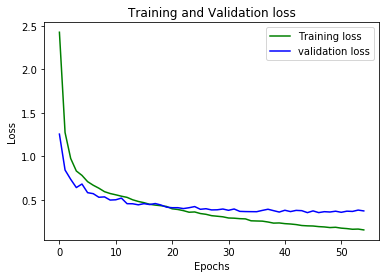

In [72]:
loss_train = vgg_history.history['loss']
loss_val = vgg_history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

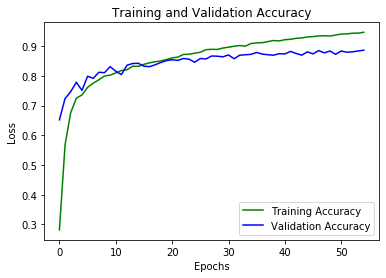

In [73]:
loss_train = vgg_history.history['accuracy']
loss_val = vgg_history.history['val_accuracy']
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
model = keras.models.load_model('vgg16-ETDclassifier_60epoch_dropout_0.8_sgd_lr1e-5.h5')

## Predict the model on Dev images (i.e., Dev Set)

In [75]:
y_pred = model.predict(X_valid, batch_size=20, verbose=1)

72/72 [==============================] - 2s 30ms/step


In [76]:
from sklearn.metrics import classification_report
y_predict = np.argmax(y_pred, axis=1)

In [77]:
print(classification_report(le.inverse_transform(Y_valid), le.inverse_transform(y_predict)))

                       precision    recall  f1-score   support

       Label-Abstract       0.99      0.94      0.96       172
Label-Acknowledgement       0.99      0.90      0.95       165
     Label-Appendices       0.73      0.54      0.62       153
       Label-Chapters       0.75      0.71      0.73       191
     Label-Dedication       0.99      0.99      0.99       144
  Label-ListofFigures       0.87      0.61      0.72        95
   Label-ListofTables       0.75      0.86      0.80       113
  Label-ReferenceList       0.88      0.94      0.91       168
 Label-TableofContent       0.70      0.98      0.82       128
      Label-TitlePage       0.78      0.97      0.87        96

             accuracy                           0.84      1425
            macro avg       0.84      0.84      0.84      1425
         weighted avg       0.85      0.84      0.84      1425



## Predict on unseen test set (ETD500)

In [ ]:
#model = keras.models.load_model('vgg16-ETDclassifier_25epoch_dropout_0.8.h5')

In [78]:
y_test_pred = model.predict(test_img, verbose=1)

14/14 [==============================] - 1s 53ms/step


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_test_predicted = np.argmax(y_test_pred, axis=1)
print(classification_report(le.inverse_transform(test_y), le.inverse_transform(y_test_predicted)))

                       precision    recall  f1-score   support

       Label-Abstract       1.00      0.70      0.82        46
Label-Acknowledgement       1.00      0.55      0.71        33
     Label-Appendices       0.00      0.00      0.00        15
       Label-Chapters       0.00      0.00      0.00        80
     Label-Dedication       1.00      0.77      0.87        65
  Label-ListofFigures       0.00      0.00      0.00        15
   Label-ListofTables       0.00      0.00      0.00        15
  Label-ReferenceList       0.16      0.93      0.28        15
 Label-TableofContent       0.21      1.00      0.34        15
      Label-TitlePage       0.77      0.98      0.86       129

             accuracy                           0.60       428
            macro avg       0.41      0.49      0.39       428
         weighted avg       0.58      0.60      0.56       428



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import tensorflow
# score = tensorflow.nn.softmax(y_test_pred[0])
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(test_y[np.argmax(score)], 100 * np.max(score))
# )

In [ ]:
# pred = []
# for i in range(len(test)):
#     img = image.load_img(test['filename'][i], target_size = (224,224))
#     predict_labels = test_labels[np.argmax(y_pred, axis=1)]
#     pred.append(predict_labels)
#     print(predict_labels)
#     plt.figure(figsize=(20,10))
#     plt.imshow(img)
#     plt.show()

In [ ]:
pred_val = pd.DataFrame(pred, columns = ['predicted_label'])
pred_val.to_csv('etd_result600.csv', encoding = 'utf-8', index= None)

In [ ]:
df1 = pd.read_csv('etd_result600.csv')
df2 = pd.read_csv('test.csv')

df3 = df1['predicted_label']
df4 = df2['labels']
result = pd.concat([df4, df3], axis = 1, sort = False)
result.to_csv("output_etd600.csv", index = None, encoding = 'utf-8')

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(df4, df3)
print("VGG16 Model Accuracy: {:.2f}%".format(acc * 100))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_y, pred))